In [2]:
import pandas as pd
import os
import opendatasets as od
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import cv2 as cv
import random as rnd
from functions import *

In [3]:
get_class_directories()

['jellyfish-types/compass_jellyfish/',
 'jellyfish-types/Moon_jellyfish/',
 'jellyfish-types/blue_jellyfish/',
 'jellyfish-types/lions_mane_jellyfish/',
 'jellyfish-types/barrel_jellyfish/']

In [4]:
len(get_jpgs())

737

### Generating Dataset

In [5]:
def get_imgs():
    imgs = []
    for cd in get_class_directories():
        for i in range(100):
            imgs.append(cd + os.listdir(cd)[i])
    return imgs

In [6]:
len(get_imgs())

500

In [7]:
def get_target():
    target = []
    imgs = get_imgs()
    for i in range(len(imgs)):
        if 'compass' in imgs[i]:
            target.append('compass')
        elif 'Moon' in imgs[i]:
            target.append('Moon')
        elif 'blue' in imgs[i]:
            target.append('blue')
        elif 'lions_mane' in imgs[i]:
            target.append('lions_mane')
        elif 'barrel' in imgs[i]:
            target.append('barrel')
    return target

In [8]:
def get_x_data():
    imgs = get_imgs()
    x = []
    for i in range(len(imgs)):
        img_data = resize(cv.imread(imgs[i]), (224, 224))
        x.append(img_data)
    return np.asarray(x)

In [9]:
x = get_x_data()

In [10]:
y = get_target()

In [11]:
y = pd.get_dummies(pd.DataFrame(y))

In [12]:
y = y.replace({True: 1, False: 0})

In [13]:
y = np.asarray(y)

### Augmentation

In [14]:
from tensorflow.keras.layers import RandomZoom, RandomContrast, RandomRotation

In [15]:
data_augmentation_layers = [
    RandomZoom((0.1, 0.5)),
    RandomRotation(0.5),
    RandomContrast(0.2)
]


def data_augmentation(imgs):
    for layer in data_augmentation_layers:
        imgs = layer(imgs)
    return imgs

In [16]:
augmented_x = data_augmentation(x)

2024-04-29 13:40:06.315173: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/clay/.local/lib/python3.8/site-packages/cv2/../../lib64:
2024-04-29 13:40:06.315242: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-04-29 13:40:06.315261: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-AB0NGOS5): /proc/driver/nvidia/version does not exist
2024-04-29 13:40:06.317166: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)

### VGG16 Model 1

In [19]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout, Rescaling
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import vgg16

In [20]:
def VGGModel1(input_shape):
    base = VGG16(input_shape = input_shape, weights = 'imagenet',
                    include_top = False, pooling = 'avg')
    base.trainable = False
    
    inputs = Input(input_shape)
    x = vgg16.preprocess_input(inputs)
    x = Dropout(0.3)(x)
    x = base(x)
    outputs = Dense(5, activation = 'softmax')(x)
    
    return Model(inputs, outputs, name = 'VGGModel1')

In [21]:
vgg_model = VGGModel1(input_shape = (224, 224, 3))

In [21]:
vgg_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [22]:
vgg_history = vgg_model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 10)

Epoch 1/10
11/11 [==============================] - 61s 6s/step - loss: 5.5319 - accuracy: 0.2400 - val_loss: 3.9306 - val_accuracy: 0.2867
Epoch 2/10
11/11 [==============================] - 64s 6s/step - loss: 3.5112 - accuracy: 0.3629 - val_loss: 2.7266 - val_accuracy: 0.3533
Epoch 3/10
11/11 [==============================] - 63s 6s/step - loss: 2.3351 - accuracy: 0.4600 - val_loss: 2.1552 - val_accuracy: 0.4333
Epoch 4/10
11/11 [==============================] - 67s 6s/step - loss: 1.6456 - accuracy: 0.5857 - val_loss: 1.8750 - val_accuracy: 0.5200
Epoch 5/10
11/11 [==============================] - 66s 6s/step - loss: 1.3458 - accuracy: 0.6514 - val_loss: 1.7381 - val_accuracy: 0.5600
Epoch 6/10
11/11 [==============================] - 65s 6s/step - loss: 0.9688 - accuracy: 0.7114 - val_loss: 1.5782 - val_accuracy: 0.6067
Epoch 7/10
11/11 [==============================] - 66s 6s/step - loss: 0.8025 - accuracy: 0.7600 - val_loss: 1.5491 - val_accuracy: 0.6067
Epoch 8/10
11/11 [==

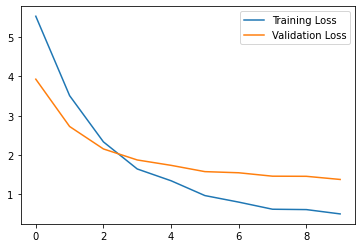

In [23]:
plt.plot(range(len(vgg_history.history['loss'])), vgg_history.history['loss'], label = 'Training Loss')
plt.plot(range(len(vgg_history.history['val_loss'])), vgg_history.history['val_loss'], label = 'Validation Loss')
plt.legend()

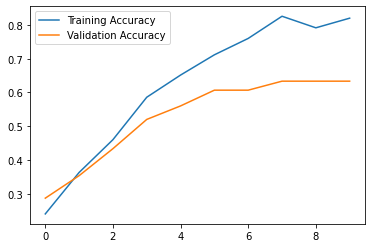

In [24]:
plt.plot(range(len(vgg_history.history['accuracy'])), vgg_history.history['accuracy'], label = 'Training Accuracy')
plt.plot(range(len(vgg_history.history['val_accuracy'])), vgg_history.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend()

In [22]:
from tensorflow.keras.metrics import AUC

In [23]:
def get_vgg_model():
    vgg_model = VGGModel1(input_shape = (224, 224, 3))
    vgg_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = [AUC(multi_label = True, num_labels = 5)])
    return vgg_model

vgg_model = get_vgg_model()

vgg_model.fit(x_test, y_test, epochs = 10)

vgg_model.save('my_vgg_model.keras')

Epoch 1/10
5/5 [==============================] - 15s 3s/step - loss: 7.7972 - auc: 0.5088
Epoch 2/10
5/5 [==============================] - 15s 3s/step - loss: 5.5351 - auc: 0.5658
Epoch 3/10
5/5 [==============================] - 17s 3s/step - loss: 4.1165 - auc: 0.5858
Epoch 4/10
5/5 [==============================] - 16s 3s/step - loss: 3.3753 - auc: 0.6517
Epoch 5/10
5/5 [==============================] - 18s 4s/step - loss: 2.6401 - auc: 0.6950
Epoch 6/10
5/5 [==============================] - 18s 4s/step - loss: 2.1706 - auc: 0.7752
Epoch 7/10
5/5 [==============================] - 18s 4s/step - loss: 1.9214 - auc: 0.8052
Epoch 8/10
5/5 [==============================] - 18s 4s/step - loss: 1.4778 - auc: 0.8630
Epoch 9/10
5/5 [==============================] - 18s 4s/step - loss: 1.2887 - auc: 0.8791
Epoch 10/10
5/5 [==============================] - 18s 4s/step - loss: 1.2910 - auc: 0.8775
